In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import torch

from pytorch_forecasting import Baseline, DeepAR, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import SMAPE, MultivariateNormalDistributionLoss


import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, 'C:\\Users\\Owner\\AppLearner\\src')
import framework__data_set as ds

In [51]:
dataset = ds.get_data_set(
    metric="container_cpu",
    application_name="dns",
    path_to_data="C:\\Users\\Owner\\AppLearner\\data\\OperatreFirst_PrometheusData_AppLearner\\"
)

In [49]:
dataset.filter_data_that_is_too_short(50)
train, test = dataset.split_to_train_and_test(20)

In [50]:
data = pd.concat(train,ignore_index=True)
data

,sample,series,time,time_idx
0,0.000364,250,2022-06-12 03:01:00,0
1,0.001862,250,2022-06-12 03:02:00,1
2,0.002779,250,2022-06-12 03:03:00,2
3,0.004179,250,2022-06-12 03:04:00,3
4,0.005884,250,2022-06-12 03:05:00,4
...,...,...,...,...
1494497,0.004337,25,2022-05-02 18:40:00,939
1494498,0.005174,25,2022-05-02 18:41:00,940
1494499,0.005839,25,2022-05-02 18:42:00,941
1494500,0.006199,25,2022-05-02 18:43:00,942


In [42]:
import os
import warnings

warnings.filterwarnings("ignore")

In [44]:
ds.split_to_train_and_test(data)

AttributeError: module 'framework__data_set' has no attribute 'split_to_train_and_test'

In [14]:
# data = generate_ar_data(seasonality=10.0, timesteps=400, n_series=100, seed=42)
# data["static"] = 2
# data["date"] = pd.Timestamp("2020-01-01") + pd.to_timedelta(data.time_idx, "D")
# data

,series,time_idx,value,static,date
0,0,0,-0.000000,2,2020-01-01
1,0,1,-0.046501,2,2020-01-02
2,0,2,-0.097796,2,2020-01-03
3,0,3,-0.144397,2,2020-01-04
4,0,4,-0.177954,2,2020-01-05
...,...,...,...,...,...
39995,99,395,-5.587069,2,2021-01-30
39996,99,396,-4.986342,2,2021-01-31
39997,99,397,-5.630228,2,2021-02-01
39998,99,398,-5.745145,2,2021-02-02


In [43]:
data = data.astype(dict(series=str))


In [16]:
max_encoder_length = 60
max_prediction_length = 20

training_cutoff = data["time_idx"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="value",
    categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["series"],
    static_categoricals=[
        "series"
    ],  # as we plan to forecast correlations, it is important to use series characteristics (e.g. a series identifier)
    time_varying_unknown_reals=["value"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
)

validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)
batch_size = 128
# synchronize samples in each batch over time - only necessary for DeepVAR, not for DeepAR
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0, batch_sampler="synchronized" #?
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size, num_workers=0, batch_sampler="synchronized" #?
)

In [43]:
[y[0] for x, y in iter(val_dataloader)]

[tensor([[ 2.0388e+00,  1.7878e+00,  2.2029e+00,  ...,  2.5379e+00,
           2.3541e+00,  2.3235e+00],
         [ 8.7418e-01,  1.0387e+00,  1.0522e+00,  ...,  1.1287e+00,
           1.0512e+00,  1.1186e+00],
         [ 1.4580e+00,  1.4866e+00,  1.2217e+00,  ...,  1.2809e+00,
           1.2561e+00,  1.6840e+00],
         ...,
         [ 1.6189e+00,  1.4709e+00,  1.4108e+00,  ...,  1.5797e+00,
           1.5581e+00,  1.5454e+00],
         [-1.8162e-02, -5.5143e-03,  8.7946e-03,  ...,  2.2106e-02,
           7.8088e-03, -7.3420e-03],
         [-4.5210e+00, -4.4483e+00, -3.9518e+00,  ..., -5.6302e+00,
          -5.7451e+00, -4.6900e+00]])]

In [17]:
training_cutoff

379

In [23]:
# calculate baseline absolute error
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
SMAPE()(baseline_predictions, actuals)

tensor(0.5462)

In [44]:
pl.seed_everything(42)
import pytorch_forecasting as ptf

trainer = pl.Trainer(gpus=0, gradient_clip_val=1e-1)
net = DeepAR.from_dataset(
    training, learning_rate=3e-2, hidden_size=30, rnn_layers=2, loss=MultivariateNormalDistributionLoss(rank=30)
)

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [45]:
res = trainer.tuner.lr_find(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    min_lr=1e-5,
    max_lr=1e0,
    early_stop_threshold=100,
)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

Finding best initial lr: 100%|██████████| 100/100 [00:33<00:00,  2.96it/s]
Restoring states from the checkpoint path at c:\Users\Owner\AppLearner\Notebooks\.lr_find_db209b4f-add8-457d-9849-080c737f8197.ckpt


KeyError: 'radam_buffer'

In [46]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=30,
    gpus=0,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    limit_train_batches=50,
    enable_checkpointing=True,
)


net = DeepAR.from_dataset(
    training,
    learning_rate=0.1,
    log_interval=10,
    log_val_interval=1,
    hidden_size=30,
    rnn_layers=2,
    loss=MultivariateNormalDistributionLoss(rank=30),
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                   | Type                               | Params
------------------------------------------------------------------------------
0 | loss                   | MultivariateNormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList                         | 0     
2 | embeddings             | MultiEmbedding                     | 2.1 K 
3 | rnn                    | LSTM                               | 13.9 K
4 | distribution_projector | Linear                             | 992   
------------------------------------------------------------------------------
17.0 K    Trainable params
0         Non-trainable params
17.0 K    Total params
0.068     Total estimated model params size (MB)


Epoch 22:  18%|█▊        | 9/51 [00:03<00:17,  2.47it/s, loss=-150, v_num=1, train_loss_step=-86.2, val_loss=-76.8, train_loss_epoch=-154.] 

In [20]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = DeepAR.load_from_checkpoint(best_model_path)

In [23]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_model.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(0.2680)

In [24]:
raw_predictions, x = net.predict(val_dataloader, mode="raw", return_x=True, n_samples=100)

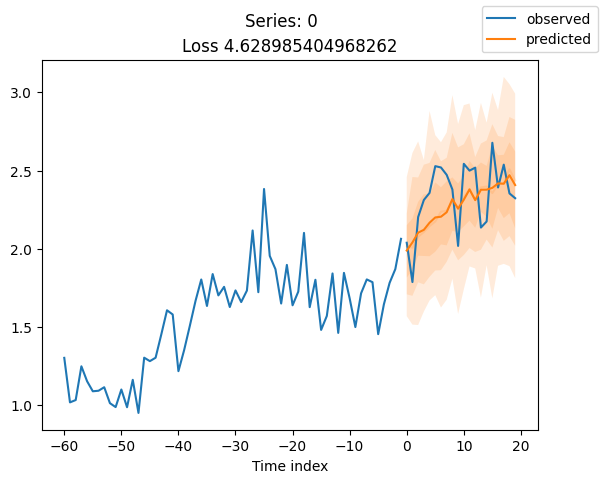

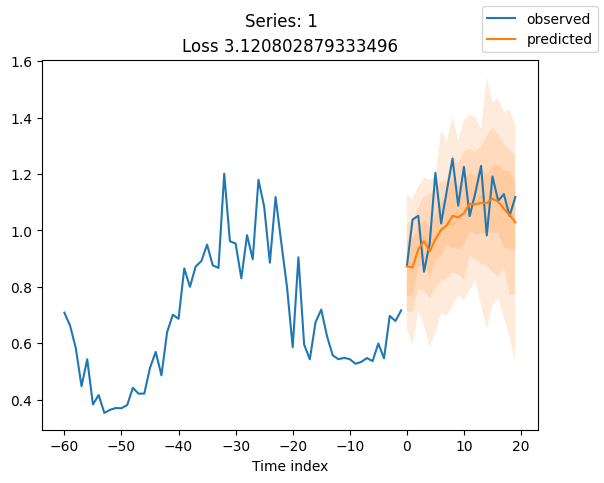

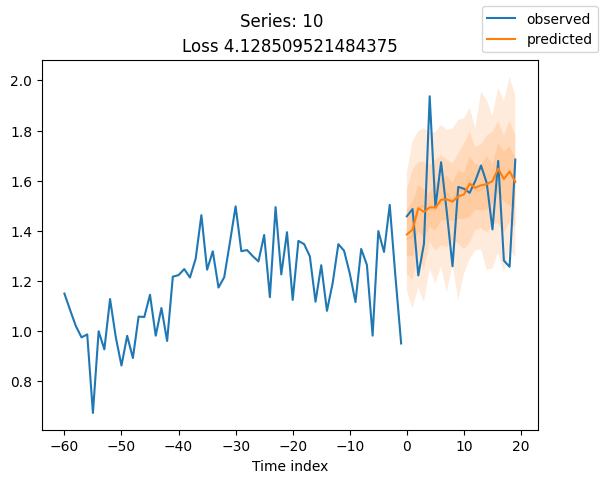

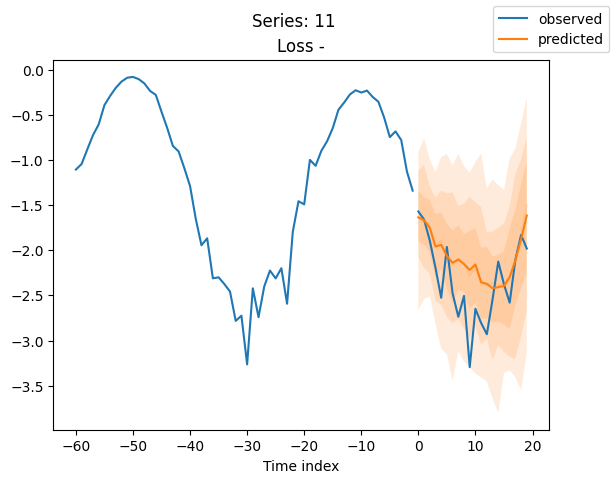

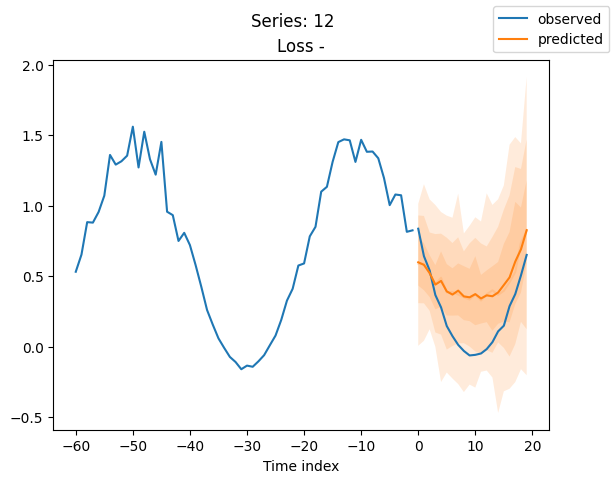

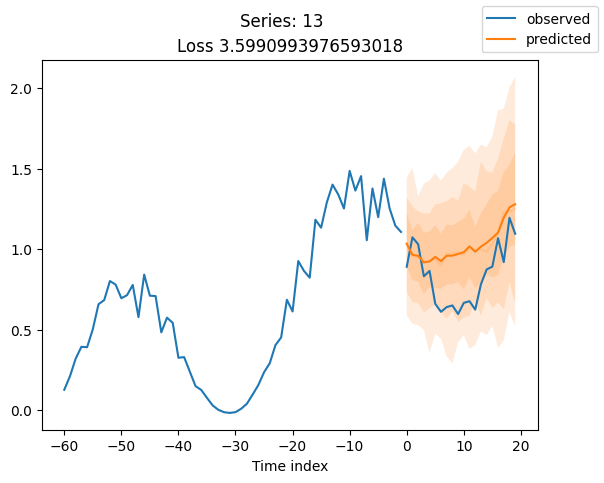

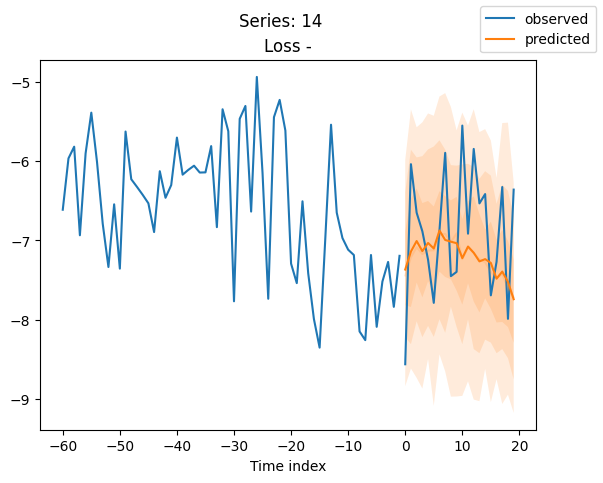

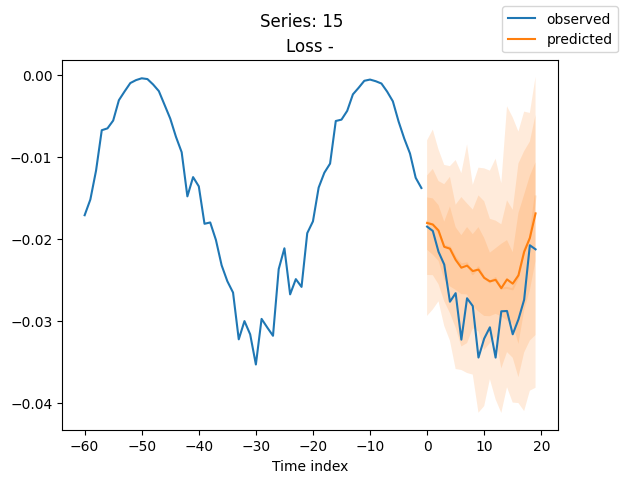

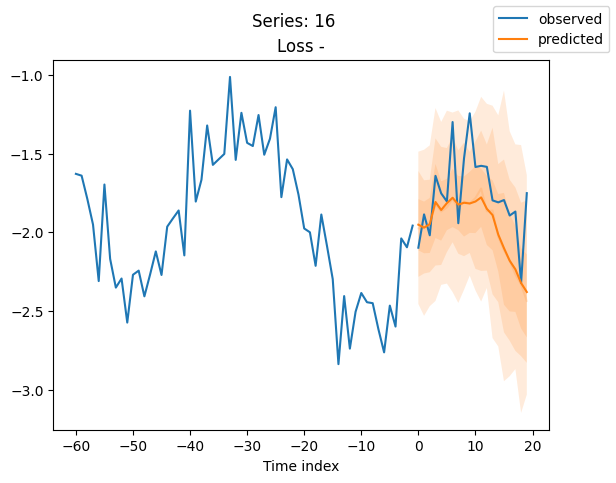

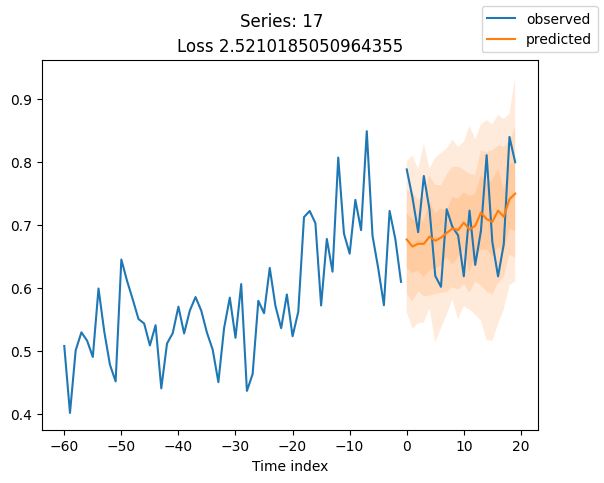

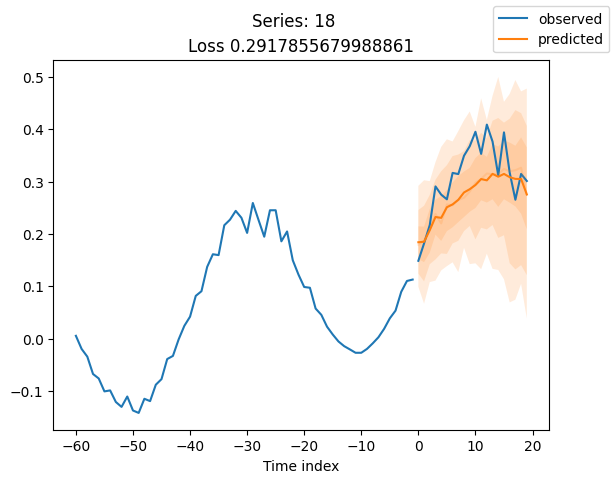

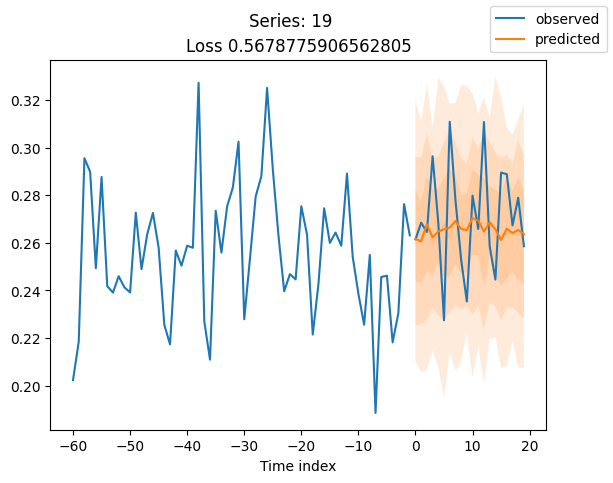

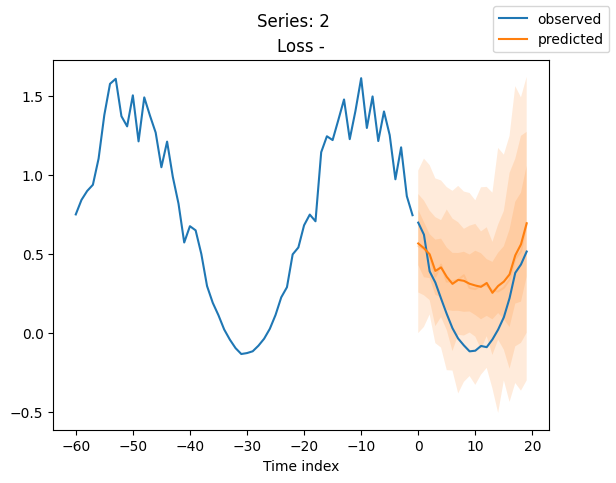

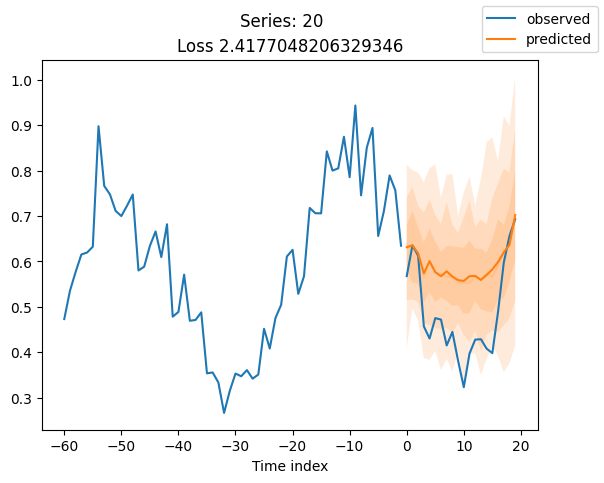

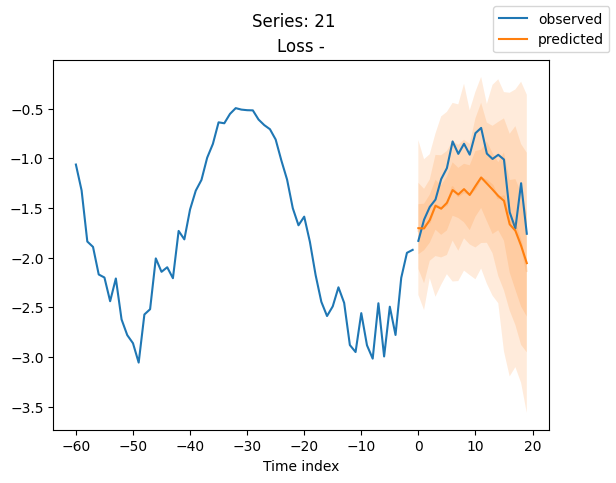

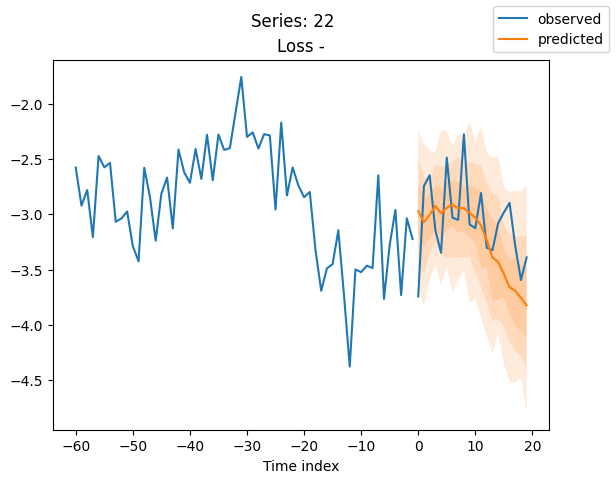

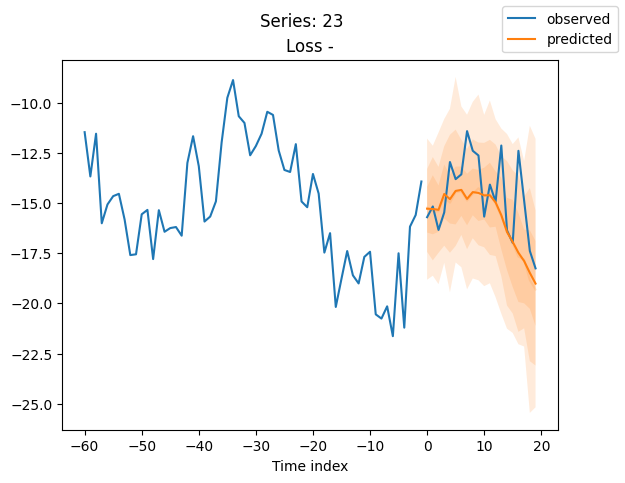

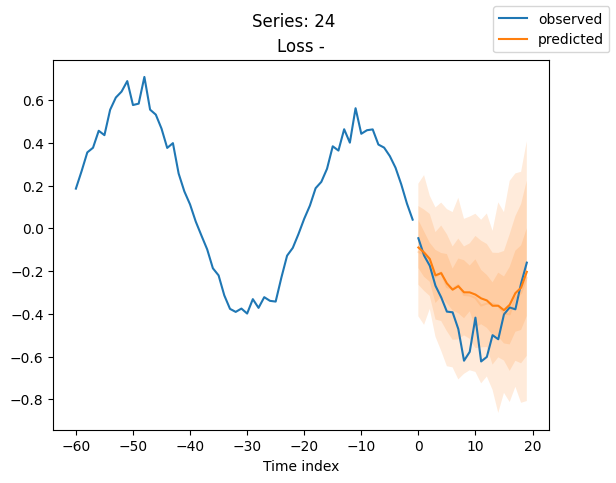

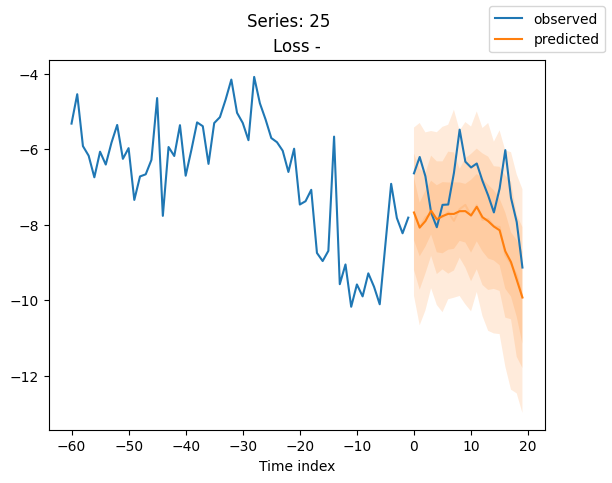

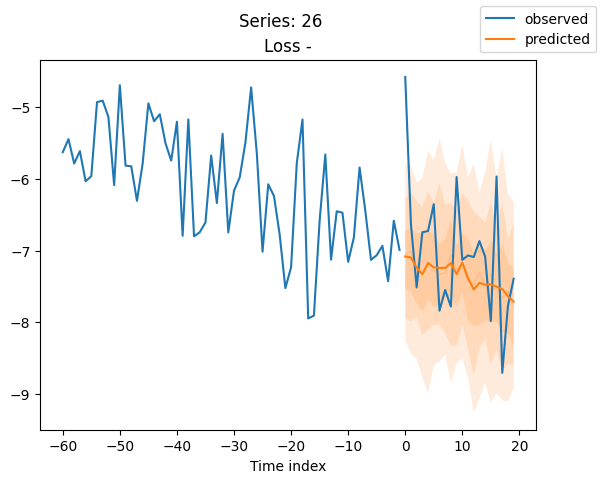

In [25]:
series = validation.x_to_index(x)["series"]
for idx in range(20):  # plot 10 examples
    best_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True)
    plt.suptitle(f"Series: {series.iloc[idx]}")